<a href="https://colab.research.google.com/github/florian-tmsp/econom-trie---Rstudio/blob/master/training_Finlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
! pip install pytorch-pretrained-bert==0.6.2 scikit-learn==0.21.2 spacy==2.1.4 torch==1.1.0 transformers==2.8.0

In [37]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import random
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [38]:
df = pd.read_csv("/home/train.csv", sep="@")
df.columns = ['text', 'sentiment']
print(df.sentiment)

0        neutral
1       negative
2       positive
3       positive
4       positive
          ...   
4840    negative
4841     neutral
4842    negative
4843    negative
4844    negative
Name: sentiment, Length: 4845, dtype: object


In [39]:
def to_sentiment(rating):
  rating = str(rating)
  if rating == 'negative':
    return 0
  elif rating == 'neutral':
    return 1
  else: 
    return 2

df['sentiment'] = df.sentiment.apply(to_sentiment)
df.head()


,text,sentiment
0,Technopolis plans to develop in stages an area...,1
1,The international electronic industry company ...,0
2,With the new production plant the company woul...,2
3,According to the company 's updated strategy f...,2
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,2


In [40]:
class_names = ['negative', 'neutral', 'positive']

In [41]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [42]:

token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

In [43]:
token_lens = []

for txt in df.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

print('len', token_lens)


len [37, 43, 36, 52, 45, 60, 43, 36, 35, 43, 54, 48, 53, 51, 46, 73, 61, 32, 36, 27, 50, 66, 57, 50, 47, 39, 41, 40, 39, 46, 48, 44, 39, 39, 58, 37, 70, 27, 41, 51, 52, 57, 33, 10, 13, 16, 44, 34, 57, 36, 67, 48, 73, 56, 35, 59, 37, 62, 31, 26, 19, 85, 44, 36, 72, 72, 79, 37, 30, 44, 19, 31, 42, 66, 33, 37, 47, 67, 67, 40, 20, 36, 32, 55, 28, 51, 25, 39, 25, 38, 43, 57, 41, 43, 41, 44, 47, 15, 26, 40, 22, 30, 16, 19, 34, 34, 27, 44, 21, 28, 29, 26, 43, 29, 39, 27, 17, 28, 26, 23, 55, 26, 39, 48, 16, 21, 45, 34, 16, 39, 26, 38, 23, 24, 24, 31, 29, 59, 40, 33, 29, 41, 34, 43, 28, 54, 37, 38, 36, 25, 41, 21, 22, 18, 14, 38, 35, 25, 22, 45, 40, 41, 38, 37, 37, 43, 41, 42, 42, 42, 40, 40, 41, 43, 41, 10, 11, 24, 44, 26, 26, 26, 26, 21, 19, 39, 68, 22, 50, 71, 41, 64, 61, 68, 49, 60, 59, 56, 62, 64, 50, 22, 33, 34, 50, 34, 24, 47, 56, 19, 20, 48, 38, 35, 33, 32, 36, 36, 36, 37, 30, 20, 32, 49, 28, 26, 65, 62, 63, 64, 72, 22, 25, 70, 30, 26, 24, 29, 28, 25, 58, 22, 20, 28, 26, 28, 28, 24, 28,

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


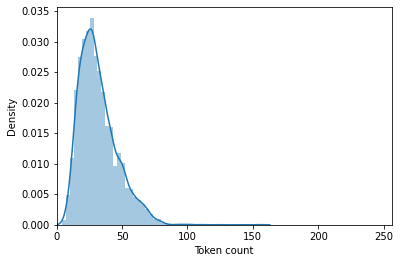

In [44]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 120tokens, but we'll be on the safe side and choose a maximum length of 160.

In [45]:
MAX_LEN = 150

In [46]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [47]:
RANDOM_SEED = random.seed(10)

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((4360, 2), (242, 2), (243, 2))

In [48]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [49]:
BATCH_SIZE = 1

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

train_data_loader

TRAINING

In [50]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [51]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [52]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [54]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [55]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.8333550428578613 accuracy 0.593119266055046
Val   loss 2.131332525537034 accuracy 0.5743801652892562

Epoch 2/10
----------
Train loss 1.91463529265255 accuracy 0.5956422018348624
Val   loss 2.11052148893845 accuracy 0.5743801652892562

Epoch 3/10
----------
Train loss 1.9226328530442824 accuracy 0.5956422018348624
Val   loss 2.0675675701503913 accuracy 0.5743801652892562

Epoch 4/10
----------
Train loss 1.90851386799178 accuracy 0.5956422018348624
Val   loss 2.0651655837524037 accuracy 0.5743801652892562

Epoch 5/10
----------
Train loss 1.7641480872937298 accuracy 0.6059633027522936
Val   loss 1.486691855694637 accuracy 0.640495867768595

Epoch 6/10
----------
Train loss 1.29993679921288 accuracy 0.7061926605504587
Val   loss 1.2576893449814852 accuracy 0.756198347107438

Epoch 7/10
----------
Train loss 1.0454693802999795 accuracy 0.7811926605504588
Val   loss 1.2571110301766515 accuracy 0.768595041322314

Epoch 8/10
----------
Train loss 0.760889

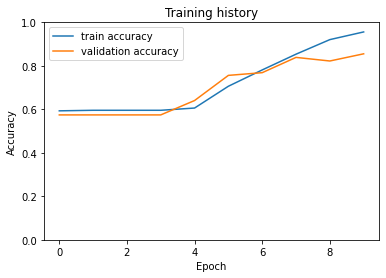

In [56]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [57]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.823045267489712

In [61]:
import torch.nn.functional as F

In [62]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [64]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [65]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.85      0.88        33
     neutral       0.86      0.85      0.86       142
    positive       0.72      0.75      0.73        68

    accuracy                           0.82       243
   macro avg       0.83      0.82      0.82       243
weighted avg       0.83      0.82      0.82       243



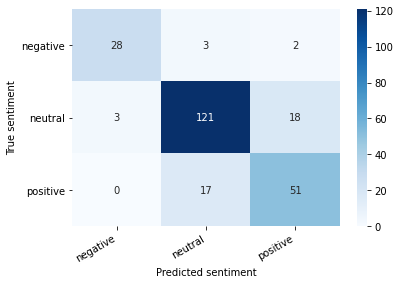

In [66]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [67]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [68]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

The company 's operating income ( EBIT ) totalled EUR 0.0 mn , up from
EUR -0.3 mn year-on-year .

True sentiment: positive


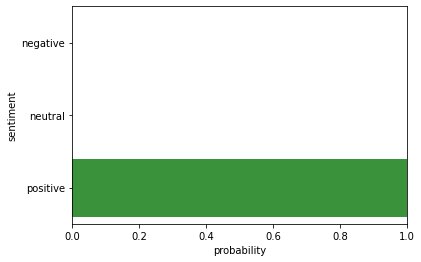

In [69]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

Predict on text

In [70]:
review_text = "Taiwanese-owned Wistron, which is a contract manufacturer for Apple, apologized for mishandling wages at its plant in India, saying it will correct the problems that led a group of angry workers to damage its facilities a week ago."

In [71]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [72]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Taiwanese-owned Wistron, which is a contract manufacturer for Apple, apologized for mishandling wages at its plant in India, saying it will correct the problems that led a group of angry workers to damage its facilities a week ago.
Sentiment  : negative
